In [1]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
import os
import re
import pprint
import tensorflow as tf

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
load_dotenv(find_dotenv())

%load_ext autoreload
%autoreload 2
os.getcwd()

'/srv/idp-radio-1'

In [2]:
# Run this before loading other dependencies, otherwise they might occupy memory on gpu 0 by default and it will stay that way

# Specify which GPU(s) to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Or 2, 3, etc. other than 0

config = tf.compat.v1.ConfigProto(device_count={'GPU': 1}, allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1.0
tf.compat.v1.Session(config=config)


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:04:00.0, compute capability: 7.5



In [3]:
from src.architectures.benchmarks.benchmark_definitions import Chexpert_Benchmark, Chestxray14_Benchmark, simple_architecture_experiment, generate_benchmarks, METRICS, CHEXPERT_COLUMNS, CHESTXRAY14_COLUMNS


In [4]:
reduced_columns = ['Enlarged Cardiomediastinum',
                    'Cardiomegaly',
                    'Lung Opacity',
                    'Lung Lesion',
                    'Edema',
                    'Consolidation',
                    'Pneumonia',
                    'Atelectasis',
                    'Pneumothorax',
                    'Pleural Effusion',
                    'Pleural Other',
                    'Fracture']


uzeros = ['Cardiomegaly',
        'Enlarged Cardiomediastinum',
        'Lung Opacity',
        'Lung Lesion',
        'Consolidation',
        'Pneumothorax',
        'Pleural Effusion']

uones = ['Edema',
        'Atelectasis',
        'Fracture',
        'Pleural Other',
        'Pneumonia',]

upsample_factors = {
    "Enlarged Cardiomediastinum": 1,
    "Lung Lesion":1,
    #"Pneumothorax":1,
    #"Pneumonia":1,
    "Pleural Other":2,
    "Fracture":2,
}
transformations_0 = {"hist_equalization":{}}
transformations_1 = {"hist_equalization":{}, "gaussian_blur":{"kernal_size":3}}
transformations_2 = {"unsharp_mask":{"radius":2, "amount":1}}
transformations_3 = {"windowing"}
len(reduced_columns)

12

In [19]:
chexpert_benchmarks, _ = generate_benchmarks(path = Path(os.environ.get("CHEXPERT_DATASET_DIRECTORY")),
                                                     name_suffix="",
                                                     classes=reduced_columns,
                                                     test_labels = "test.csv",
                                                     split_valid_size = 0.05,
                                                     u_enc = [uzeros, uones],
                                                     # train_labels = "nofinding_train.csv",
                                                     nan_replacement = 0, #float("NaN"),
                                                     batch_sizes = {"b": 4},
                                                     epoch_sizes = {"e": 1},
                                                     dim=(320, 320),
                                                     crop = {"C0": False},
                                                     split_seed = 65748123,
                                                     augmentation=None,
                                                     transformations = transformations_2,
                                                     upsample_factors = upsample_factors)

Initialzed custom_binary_crossentropy with epsilon 1e-05
Chestxray_BCE_E1_B4_C0_N12 could not be created
Chestxray_WBCE_E1_B4_C0_N12 could not be created
Chestxray_CWBCE_E1_B4_C0_N12 could not be created


In [20]:
list(chexpert_benchmarks.keys())[0]

'BCE_E1_B4_C0_N12'

In [21]:
benchmark = chexpert_benchmarks[list(chexpert_benchmarks.keys())[0]]

In [22]:
benchmark_dict = benchmark.as_dict()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(benchmark_dict)

{   'augmentation': None,
    'batch_size': 4,
    'benchmark_name': 'Chexpert_BCE_E1_B4_C0_N12',
    'class_weights': [   1.042536973953247,
                         0.8560264706611633,
                         0.2141069769859314,
                         1.2405210733413696,
                         0.3825823664665222,
                         1.5754812955856323,
                         0.9351276159286499,
                         0.3470333218574524,
                         1.1588727235794067,
                         0.2775115370750427,
                         1.1722869873046875,
                         0.7979134321212769],
    'crop': False,
    'dataset_folder': 'data/chexpert/full',
    'dataset_name': 'chexpert_full',
    'dim': (320, 320),
    'drop_last': False,
    'epochs': 1,
    'label_columns': [   'Enlarged Cardiomediastinum',
                         'Cardiomegaly',
                         'Lung Opacity',
                         'Lung Lesion',
                     

In [23]:
benchmark.label_columns

['Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture']

In [24]:
train_labels = benchmark.traingen.get_labels()
valid_labels = benchmark.valgen.get_labels()
test_labels = benchmark.testgen.get_labels()

print("Number train samples:", len(train_labels))
print("Number valid samples:", len(valid_labels))
print("Number test samples:", len(test_labels))

Number train samples: 266990
Number valid samples: 11550
Number test samples: 234


In [25]:
def get_distribution(labels):
    labels_df = pd.DataFrame(labels, columns=benchmark.label_columns)


    d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Negative': [], 'Negative %': [],}
    for label in labels_df.columns:
        values = labels_df.groupby(label)
        d['Pathology'].append(label)

        positive = values.size()[1.0] if 1.0 in values.size() else 0
        positive_percent = positive / labels_df.shape[0] * 100
        d['Positive'].append(positive)
        d['Positive %'].append(round(positive_percent, 2))

        negative = values.size()[-0.0] if -0.0 in values.size() else 0
        negative_percent = negative / labels_df.shape[0] * 100
        d['Negative'].append(negative)
        d['Negative %'].append(round(negative_percent, 2))
    
    df = pd.DataFrame(d)
    df = df.set_index('Pathology')

    return df

<AxesSubplot:title={'center':'Test set'}, xlabel='Pathology'>

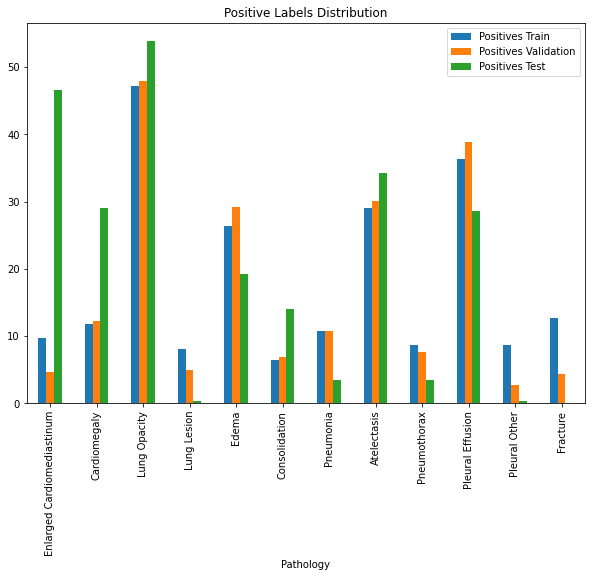

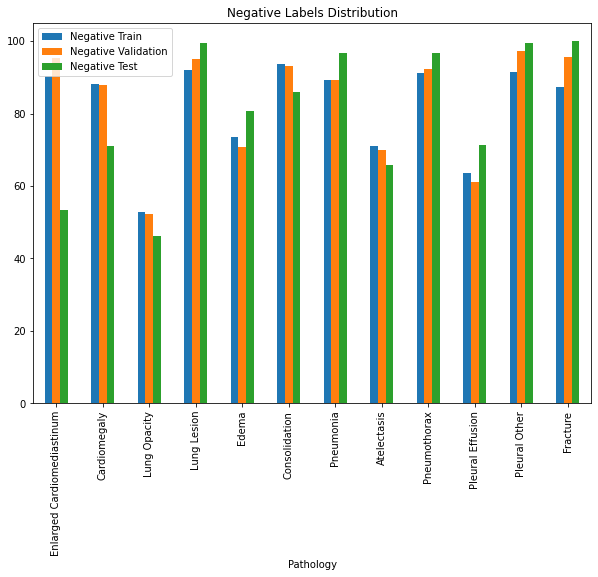

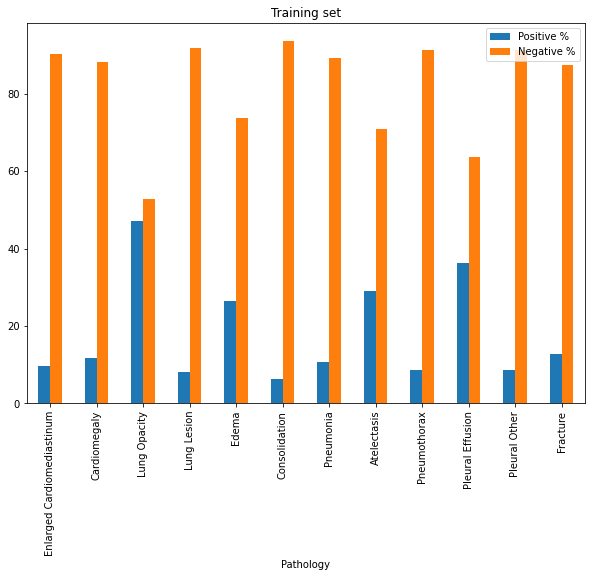

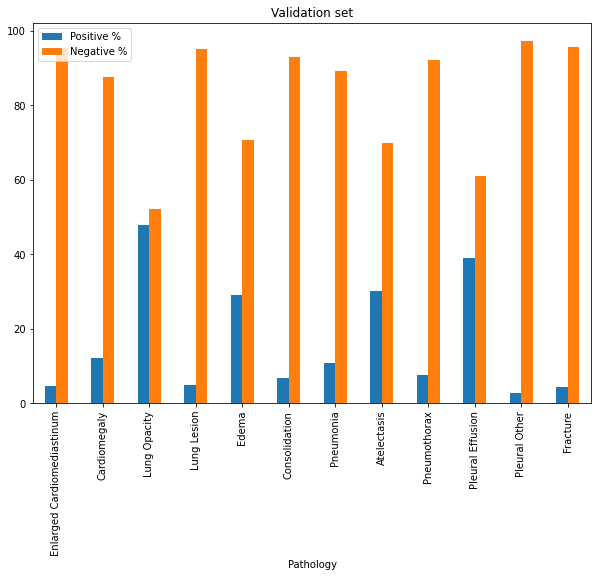

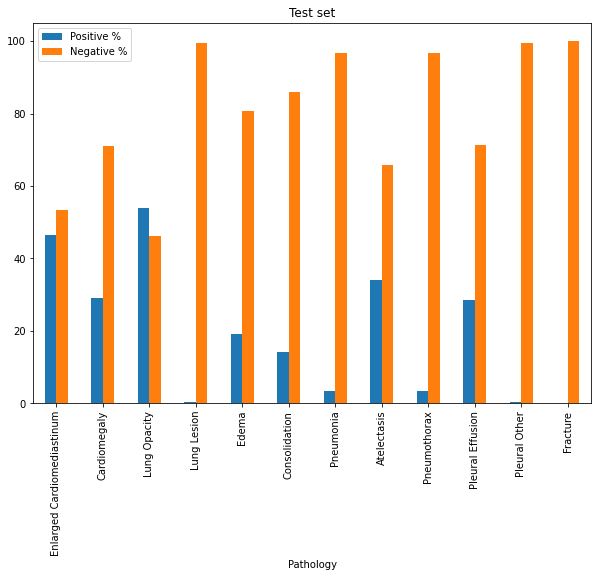

In [26]:
train = get_distribution(train_labels)
val = get_distribution(valid_labels)
test = get_distribution(test_labels)

positives = train[['Positive %']].merge(val[['Positive %']], left_index=True, right_index=True).merge(test[['Positive %']], left_index=True,  right_index=True).rename(columns={"Positive %_x": "Positives Train", "Positive %_y": "Positives Validation", "Positive %": "Positives Test", })
positives.copy().plot(kind='bar', figsize=(10,7), title="Positive Labels Distribution")

negatives = train[['Negative %']].merge(val[['Negative %']], left_index=True, right_index=True).merge(test[['Negative %']], left_index=True,  right_index=True).rename(columns={"Negative %_x": "Negative Train", "Negative %_y": "Negative Validation", "Negative %": "Negative Test", })
negatives.copy().plot(kind='bar', figsize=(10,7), title="Negative Labels Distribution")

train[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Training set")
val[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Validation set")
test[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Test set")

In [27]:
get_distribution(train_labels)

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,25840,9.68,241150,90.32
Cardiomegaly,31470,11.79,235520,88.21
Lung Opacity,125821,47.13,141169,52.87
Lung Lesion,21716,8.13,245274,91.87
Edema,70414,26.37,196576,73.63
Consolidation,17099,6.40,249891,93.60
Pneumonia,28808,10.79,238182,89.21
Atelectasis,77627,29.07,189363,70.93
Pneumothorax,23246,8.71,243744,91.29


In [28]:
get_distribution(valid_labels)

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,532,4.61,11018,95.39
Cardiomegaly,1411,12.22,10139,87.78
Lung Opacity,5528,47.86,6022,52.14
Lung Lesion,570,4.94,10980,95.06
Edema,3377,29.24,8173,70.76
Consolidation,796,6.89,10754,93.11
Pneumonia,1249,10.81,10301,89.19
Atelectasis,3475,30.09,8075,69.91
Pneumothorax,886,7.67,10664,92.33


In [29]:
get_distribution(test_labels)

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,109,46.58,125,53.42
Cardiomegaly,68,29.06,166,70.94
Lung Opacity,126,53.85,108,46.15
Lung Lesion,1,0.43,233,99.57
Edema,45,19.23,189,80.77
Consolidation,33,14.10,201,85.90
Pneumonia,8,3.42,226,96.58
Atelectasis,80,34.19,154,65.81
Pneumothorax,8,3.42,226,96.58


In [39]:
import math
def plot_batch(generator, batchnum):
    batch_size = generator.batch_size
    plot_height = 5 if batch_size > 4 else 60
    plot_width = 5 if batch_size > 4 else 60
    fig_size_x = 4 if batch_size > 4 else 1
    fig_size_y = math.ceil(batch_size / fig_size_x)
    figsize = (plot_width * fig_size_x, plot_height * fig_size_y)
    plt.figure(figsize=figsize)
    i = 0
    for img in generator[batchnum][0]:
        plt.subplot(8, 4, i+1)
        # Plot the image
        plt.imshow(img)
        plt.axis('off')
        i += 1
    plt.show()

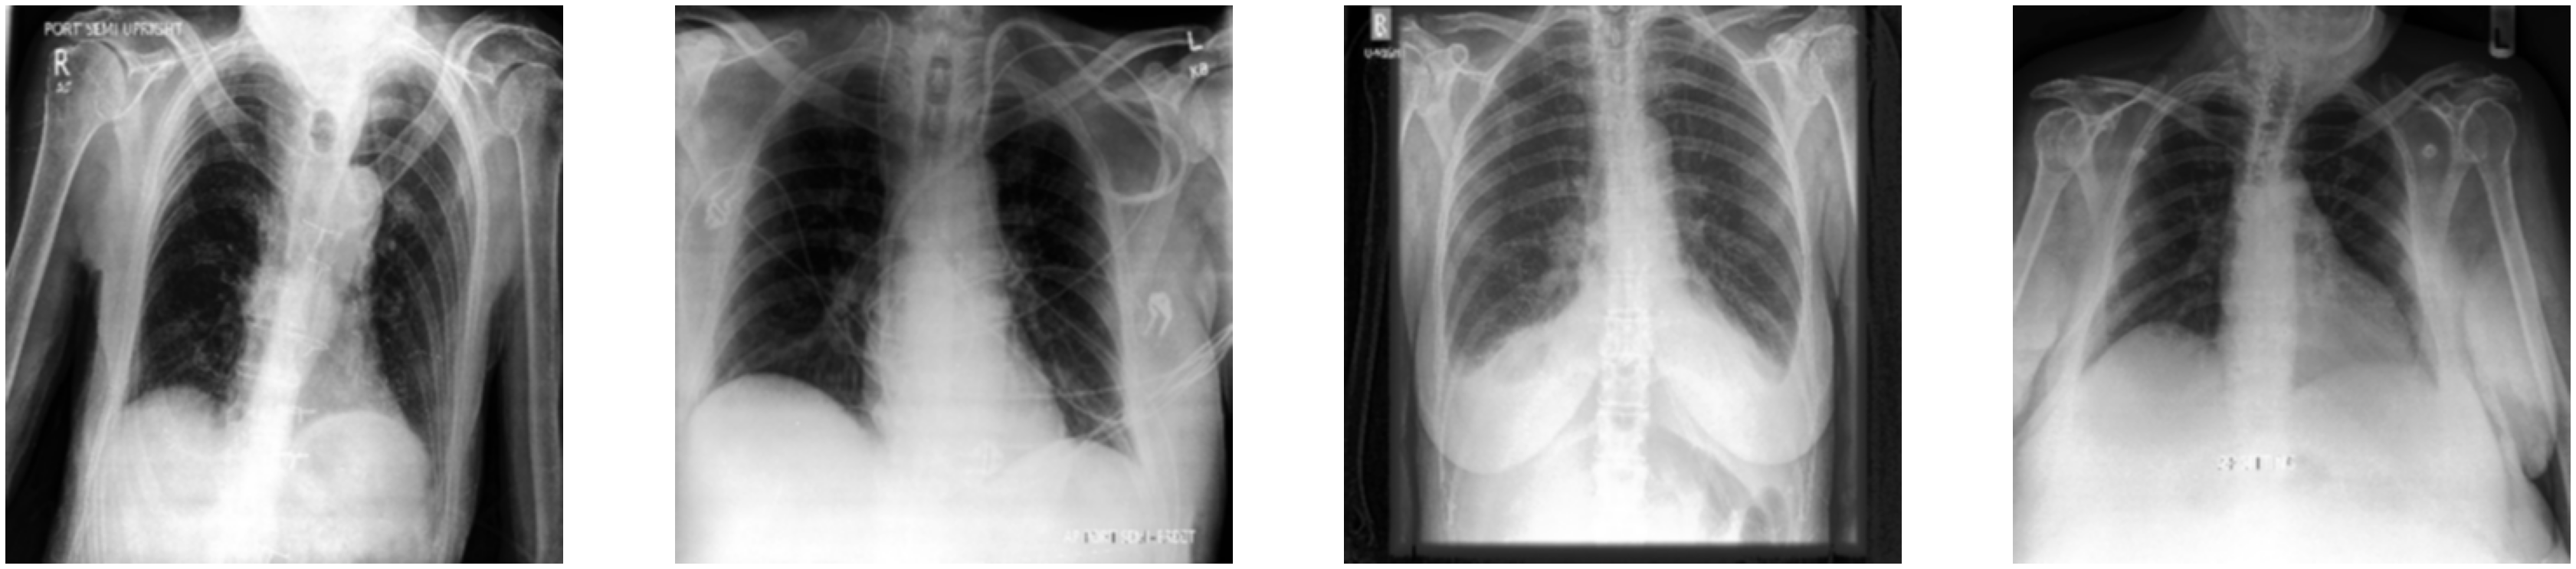

In [63]:
#unsharp_mask', 'gaussian_filter', 'windowing', 'median_filter', 'hist_equalization'
benchmark.valgen.transformations = {}#{"hist_equalization":{}, "gaussian_blur":{"kernal_size":3}}
benchmark.valgen.transformations = { "hist_equalization":{}, "gaussian_blur":{"kernal_size":3}}
plot_batch(benchmark.valgen, 5)

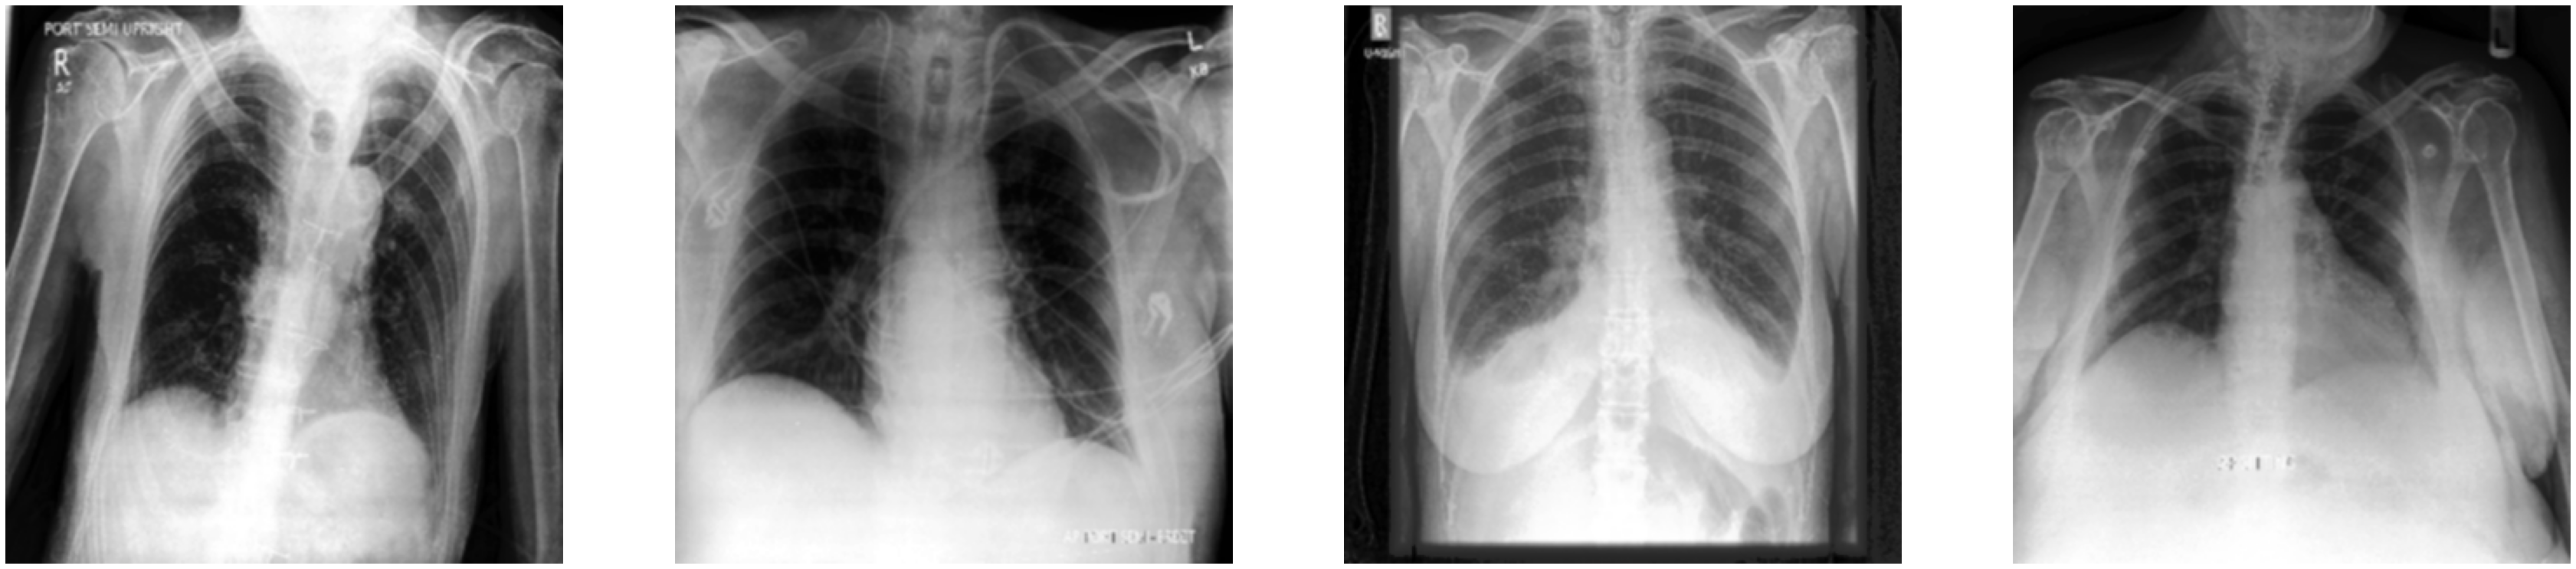

In [62]:
benchmark.valgen.transformations = {"unsharp_mask":{"radius":5, "amount":1}}
benchmark.valgen.transformations = { "gaussian_blur":{"kernal_size":3}, "hist_equalization":{}}
#benchmark.valgen.transformations = {"hist_equalization":{}}
plot_batch(benchmark.valgen, 5)

In [33]:
benchmark.testgen.batch_size

1

In [34]:
for index, value in enumerate(["No_Finding","Enlarged_Cardiomediastinum","Cardiomegaly","Lung_Opacity","Lung_Lesion","Edema","Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural_Effusion","Pleural_Other","Fracture","Support_Devices"]):
    print(index, value)

0 No_Finding
1 Enlarged_Cardiomediastinum
2 Cardiomegaly
3 Lung_Opacity
4 Lung_Lesion
5 Edema
6 Consolidation
7 Pneumonia
8 Atelectasis
9 Pneumothorax
10 Pleural_Effusion
11 Pleural_Other
12 Fracture
13 Support_Devices
